<a href="https://colab.research.google.com/github/danielcorrea96/AlgoritmosOptimizacion/blob/main/Actividad_C1_P1_Correa_Angarita_Daniel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convocatoria 1 - Proyecto 1

### Analisis sobre la imagen de historico 1:

#### 0) Cargar una de las imágenes histológicas

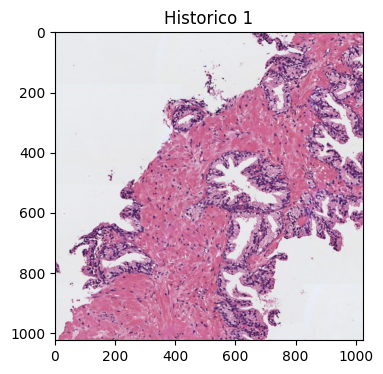

In [80]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from skimage import io

IMAGEN_1_HISTORICO = './imagenes/histo_1.jpg'

#1. Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
#2. Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
def leer_imagen_y_retornar_rgb_normalizado(ruta):
  img = io.imread(ruta)
  rgb = img.copy()
  rgb_p = rgb.astype('uint8')/255
  return rgb, rgb_p

original_imagen_1, rgb_imagen_1 = leer_imagen_y_retornar_rgb_normalizado(IMAGEN_1_HISTORICO)

#3. Visualizar la imagen
fig, axes = plt.subplots(figsize=(10, 4))
# Imagen historico 1
axes.imshow(rgb_imagen_1, cmap='gray')
axes.set_title("Historico 1")

plt.show()

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

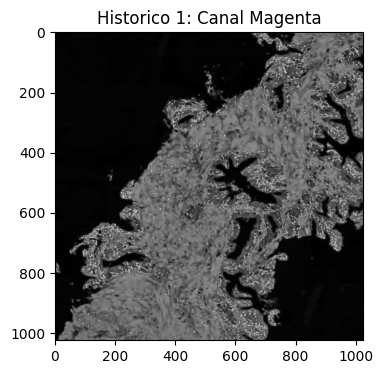

In [81]:
#1. Extraer la componente magenta de la imagen (que corresponde a la región tisular)
def devolver_imagen_convertida_a_cmyk(rgb_imagen):
  with np.errstate(invalid='ignore', divide='ignore'):
      K = 1 - np.max(rgb_imagen, axis=2)
      # Extrae los canales de acuerdo con la ecuación del power point
      C = (1-rgb_imagen[:,:,0]-K)/(1-K)
      M = (1-rgb_imagen[:,:,1]-K)/(1-K)
      Y = (1-rgb_imagen[:,:,2]-K)/(1-K)
      return (np.dstack((C,M,Y,K))*255).astype('uint8')

cmyk_imagen_1 = devolver_imagen_convertida_a_cmyk(rgb_imagen_1)

## Realizamos el split, para guardar valores en C(Cyan), M(Magenta), Y(Amarillo), K(Negro).
C,M,Y,K = cv2.split(cmyk_imagen_1)

#2. Visualizar la imagen del canal magenta
fig, axes = plt.subplots(1, 1, figsize=(10, 4))
axes.set_title("Historico 1: Canal Magenta")
axes.imshow(M.astype('uint8'), cmap='gray')
plt.show()

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

shape: (1024, 1024, 3)
dtype: float64
min/max: 0.0 1.0


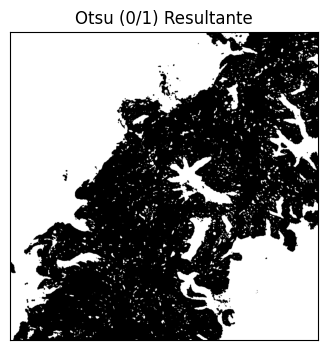

In [82]:
# 1. Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".

# Previamente hemos normalizado la imagen, entonces...

print("shape:", rgb_imagen_1.shape)
print("dtype:", rgb_imagen_1.dtype)
print("min/max:", rgb_imagen_1.min(), rgb_imagen_1.max())

## Aca nos damos cuenta que la imagen viene normalizada, entonces nos toca hacer una transformacion nuevamente
## a escala de 0-255 y float32.

def transformar_rgb_imagen_a_float32(rgb_imagen):
  imagen_float_32 = rgb_imagen.astype(np.float32)
  return imagen_float_32

rgb_imagen_1 = transformar_rgb_imagen_a_float32(rgb_imagen_1)

def gauss_outsu_lumen_bg_1(imagen_transformada):
  img_gray = cv2.cvtColor(imagen_transformada, cv2.COLOR_RGB2GRAY)
  img_u8 = (img_gray.astype(np.float32) * 255).clip(0, 255).astype(np.uint8)

  # Aplicando metodo Gauss 5 x 5 y Otsu
  blur_imagen = cv2.GaussianBlur(img_u8, (5, 5), 0)

  _, mask_otsu = cv2.threshold(blur_imagen, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  return img_gray, blur_imagen, mask_otsu

img_gray, blur_imagen, mask_otsu = gauss_outsu_lumen_bg_1(rgb_imagen_1)

# 2. Visualizar la máscara resultante

fig, axes = plt.subplots(1, 1, figsize=(12, 4))

axes.imshow(mask_otsu, cmap='gray'); axes.set_title("Otsu (0/1) Resultante"); axes.set_xticks([]); axes.set_yticks([])

plt.show()

#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

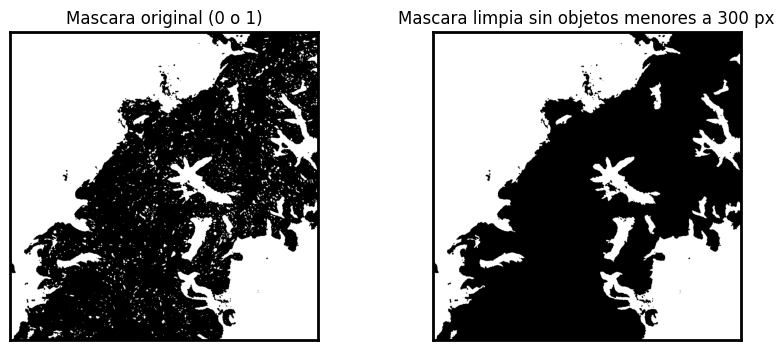

In [83]:
# 1. Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
from skimage.morphology import remove_small_objects

def remover_objetos_con_areas_seleccionadas(mask_original, pixeles):
  mask_booleana = mask_original.astype(bool) #Convertir a boolean matriz.
  # Remover los objetos pequenos menores a 300 pixeles.
  mask_limpia = remove_small_objects(mask_booleana, min_size=pixeles)

  return mask_limpia

mask_limpia_sin_300 = remover_objetos_con_areas_seleccionadas(mask_otsu, 300)
mask_limpia_sin_300_u8 = mask_limpia_sin_300.astype(np.uint8)

#2. Visualizar la máscara resultante
# Vamos a visualizar como se veia antes y despues para comparar.

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].imshow(mask_otsu, cmap='gray')
axes[0].set_title("Mascara original (0 o 1)")
axes[0].set_xticks([]); axes[0].set_yticks([])

axes[1].imshow(mask_limpia_sin_300_u8, cmap='gray')
axes[1].set_title("Mascara limpia sin objetos menores a 300 px", )
axes[1].set_xticks([]); axes[1].set_yticks([])

for a in axes:
    for s in a.spines.values():
        s.set_visible(True)
        s.set_linewidth(2)

plt.show()

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

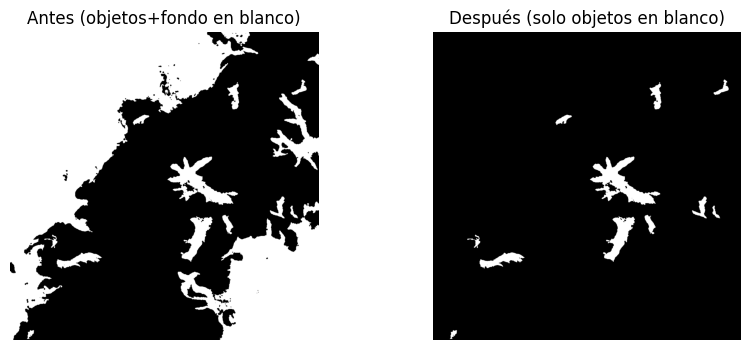

In [84]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante.

import numpy as np
from skimage.segmentation import clear_border

# Quita las regiones blancas conectadas al borde y elimina el fondo+objetos si estaban en True
def quitar_regiones_blancas_y_fondo(mask_limpia_u8):
  mask_booleana = mask_limpia_u8.astype(bool)
  m_no_bg = clear_border(mask_booleana)
  return m_no_bg.astype(np.uint8)  #elimina el fondo y deja objetos blancos

mask_lumen_aislado = quitar_regiones_blancas_y_fondo(mask_limpia_sin_300_u8)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(mask_limpia_sin_300_u8, cmap='gray')
plt.title("Antes (objetos+fondo en blanco)")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(mask_lumen_aislado, cmap='gray')
plt.title("Después (solo objetos en blanco)")
plt.axis('off')

plt.show()

#### 5) Rellenar los objetos de los lúmenes

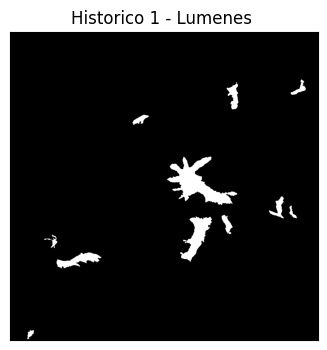

In [85]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante

from scipy.ndimage import binary_fill_holes

# Usando la funcion binary_fill_holes:

mask_lumen_aislado = binary_fill_holes(mask_lumen_aislado.copy())

# Visualizamos

fig, axes = plt.subplots(1, 1, figsize=(12, 4))
axes.imshow(mask_lumen_aislado, cmap='gray');
axes.set_title("Historico 1 - Lumenes ");
axes.set_xticks([]);
axes.set_yticks([])
plt.show()

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

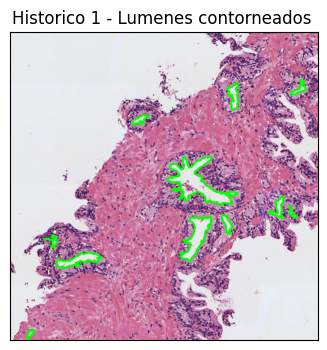

In [86]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles.
# Visualizar la imagen superpuesta

def dibujar_los_contornos_de_imagen(mask_lumen_aislado, original_imagen_1):
  contours, _ = cv2.findContours(mask_lumen_aislado.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  imagen_contornos = cv2.drawContours(original_imagen_1.copy(), contours, -1, (0, 255, 0), 6)
  return imagen_contornos

imagen_contornos = dibujar_los_contornos_de_imagen(mask_lumen_aislado, original_imagen_1)

fig, axes = plt.subplots(1, 1, figsize=(12, 4))
axes.imshow(imagen_contornos, cmap='gray');
axes.set_title("Historico 1 - Lumenes contorneados ");
axes.set_xticks([]);
axes.set_yticks([])
plt.show()

#### 7) Identificar y cropear el lumen más grande

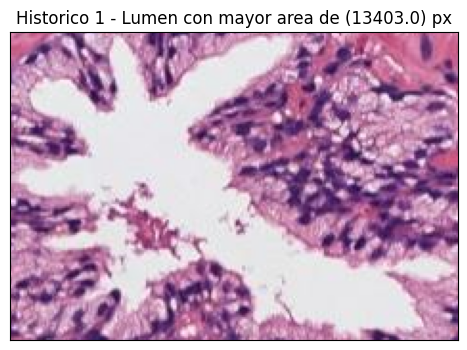

In [87]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.

from skimage.measure import label, regionprops

props = []

def obtener_propiedades_de_la_imagen(mask_lumen_aislado):
  labels, num_labels = label(mask_lumen_aislado, return_num=True)
  # Se obtiene las propiedades de cada label, para el siguiente punto.

  for posicion in range(1, num_labels + 1):
    a_label = labels == posicion

    prop = regionprops(a_label.astype(np.uint8))
    props.append(
        {
            "Lumen": posicion,
            "Area": np.round(prop[0].area, 4),
            "A. Bbox": np.round(prop[0].bbox_area, 4),
            "A. Convexa": np.round(prop[0].convex_area, 4),
            "Excentridad": np.round(prop[0].eccentricity, 4),
            "D. Equivalente": np.round(prop[0].equivalent_diameter, 4),
            "Extension": np.round(prop[0].extent, 4),
            "D. Feret": np.round(prop[0].feret_diameter_max, 4),
            "L. eje mayor": np.round(prop[0].major_axis_length, 4),
            "L. eje menor": np.round(prop[0].minor_axis_length, 4),
            "Orientacion": np.round(prop[0].orientation, 4),
            "Perimetro": np.round(prop[0].perimeter, 4),
            "Solidez": np.round(prop[0].solidity, 4),
            "Compacidad": np.round(4*math.pi*prop[0].area/prop[0].perimeter**2, 4)
        }
    )
  return props, labels

props, labels = obtener_propiedades_de_la_imagen(mask_lumen_aislado)

# Se halla la posicion y el area del lumen con el area mas grande
def hallando_el_area_y_lumen_mas_grande_de_imagen(props):
  areas = [prop["Area"] for prop in props]
  posicion_label = np.array(areas).argmax() + 1
  area_max = np.array(areas).max()
  lumen_con_mas_area = labels == posicion_label

  return area_max, lumen_con_mas_area

area_max, lumen_con_mas_area = hallando_el_area_y_lumen_mas_grande_de_imagen(props)

def hallando_bbox_de_imagen(lumen_con_mas_area):
  prop = regionprops(lumen_con_mas_area.astype(np.uint8)) # nos aseguramos u8.
  minr, minc, maxr, maxc = prop[0].bbox
  return minr, minc, maxr, maxc

minr, minc, maxr, maxc = hallando_bbox_de_imagen(lumen_con_mas_area)

## Visualizando
crop = original_imagen_1[minr:maxr, minc:maxc]

fig, axes = plt.subplots(1, 1, figsize=(12, 4))
axes.imshow(crop, cmap='gray');
axes.set_title(f"Historico 1 - Lumen con mayor area de ({area_max}) px");
axes.set_xticks([]);
axes.set_yticks([])
plt.show()

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado

In [88]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad

from tabulate import tabulate
from IPython.display import HTML, display

## Obtenemos y pintamos la tabla con los valores del lumen con area mas grande.
prop_max = max(props, key=lambda x: x["Area"])
props_max = [prop_max]
tabla_html = tabulate(props_max, headers="keys", tablefmt="html")

estilo = """
<style>
table {
    border-collapse: collapse;
    width: 100%;
    font-family: Arial, sans-serif;
}
th {
    background-color: #6C3483;
    color: white;
    padding: 8px;
}
td {
    padding: 6px;
    text-align: center;
}
tr:nth-child(even) {
    background-color: #625f63;
}
tr:hover {
    background-color: #D2B4DE;
}
</style>
"""
display(HTML(estilo + tabla_html))


Lumen,Area,A. Bbox,A. Convexa,Excentridad,D. Equivalente,Extension,D. Feret,L. eje mayor,L. eje menor,Orientacion,Perimetro,Solidez,Compacidad
4,13403,37674,27520,0.8446,130.634,0.3558,243.463,231.846,124.119,0.9972,1164.21,0.487,0.1243


### Analisis sobre la imagen de historico 2:

Vamos a reutilizar las funciones que hemos creado previamente!

#### 0) Cargar una de las imágenes histológicas

In [89]:
IMAGEN_2_HISTORICO = './imagenes/histo_2.jpg'

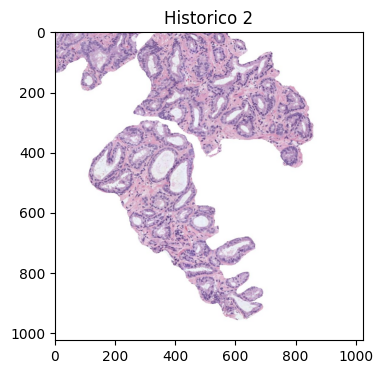

In [90]:
original_imagen_2, rgb_imagen_2 = leer_imagen_y_retornar_rgb_normalizado(IMAGEN_2_HISTORICO)

# Imagen historico 2
axes.imshow(rgb_imagen_2, cmap='gray')
axes.set_title("Historico 2")

#3. Visualizar la imagen
fig, axes = plt.subplots(figsize=(10, 4))

axes.imshow(rgb_imagen_2, cmap='gray')
axes.set_title("Historico 2")
plt.show()

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

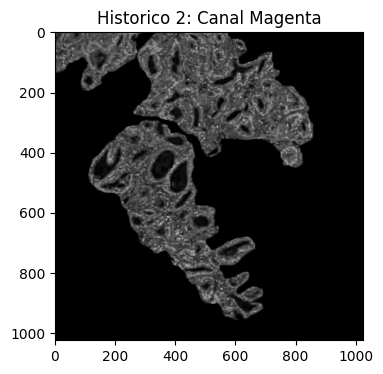

In [91]:
cmyk_imagen_2 = devolver_imagen_convertida_a_cmyk(rgb_imagen_2)

## Realizamos el split, para guardar valores en C(Cyan), M(Magenta), Y(Amarillo), K(Negro).
C,M,Y,K = cv2.split(cmyk_imagen_2)

#2. Visualizar la imagen del canal magenta
fig, axes = plt.subplots(1, 1, figsize=(10, 4))
axes.set_title("Historico 2: Canal Magenta")
axes.imshow(M.astype('uint8'), cmap='gray')
plt.show()

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

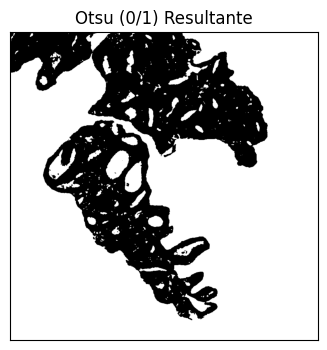

In [92]:
rgb_imagen_2 = transformar_rgb_imagen_a_float32(rgb_imagen_2)

img_gray_2, blur_imagen_2, mask_otsu_2 = gauss_outsu_lumen_bg_1(rgb_imagen_2)

# 2. Visualizar la máscara resultante

fig, axes = plt.subplots(1, 1, figsize=(12, 4))

axes.imshow(mask_otsu_2, cmap='gray'); axes.set_title("Otsu (0/1) Resultante"); axes.set_xticks([]); axes.set_yticks([])

plt.show()

#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

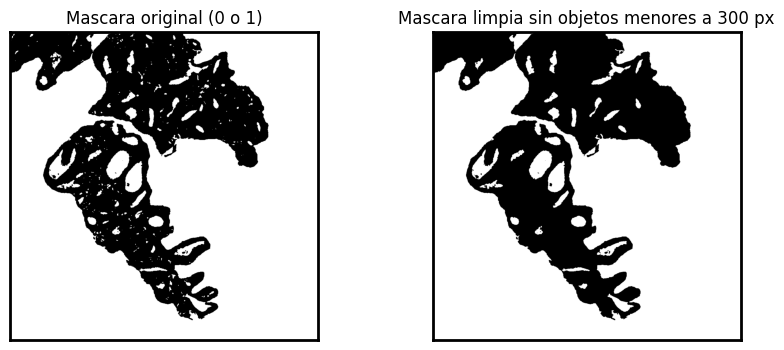

In [93]:
mask_limpia_sin_300_2 = remover_objetos_con_areas_seleccionadas(mask_otsu_2, 300)
mask_limpia_sin_300_u8_2 = mask_limpia_sin_300_2.astype(np.uint8)

#2. Visualizar la máscara resultante
# Vamos a visualizar como se veia antes y despues para comparar.

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].imshow(mask_otsu_2, cmap='gray')
axes[0].set_title("Mascara original (0 o 1)")
axes[0].set_xticks([]); axes[0].set_yticks([])

axes[1].imshow(mask_limpia_sin_300_u8_2, cmap='gray')
axes[1].set_title("Mascara limpia sin objetos menores a 300 px", )
axes[1].set_xticks([]); axes[1].set_yticks([])

for a in axes:
    for s in a.spines.values():
        s.set_visible(True)
        s.set_linewidth(2)

plt.show()

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

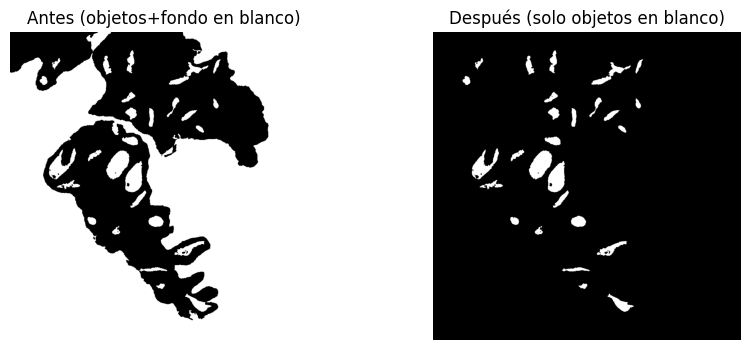

In [94]:
mask_lumen_aislado_2 = quitar_regiones_blancas_y_fondo(mask_limpia_sin_300_u8_2)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(mask_limpia_sin_300_u8_2, cmap='gray')
plt.title("Antes (objetos+fondo en blanco)")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(mask_lumen_aislado_2, cmap='gray')
plt.title("Después (solo objetos en blanco)")
plt.axis('off')

plt.show()

#### 5) Rellenar los objetos de los lúmenes

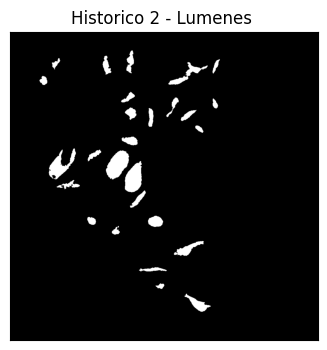

In [95]:
# Usando la funcion binary_fill_holes:

mask_lumen_aislado_2 = binary_fill_holes(mask_lumen_aislado_2.copy())

# Visualizamos

fig, axes = plt.subplots(1, 1, figsize=(12, 4))
axes.imshow(mask_lumen_aislado_2, cmap='gray');
axes.set_title("Historico 2 - Lumenes ");
axes.set_xticks([]);
axes.set_yticks([])
plt.show()

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

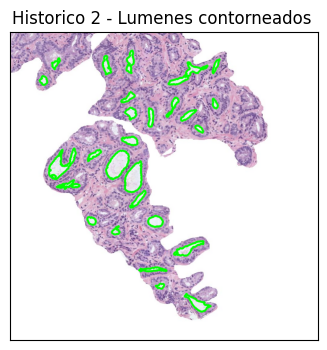

In [96]:
imagen_contornos_2 = dibujar_los_contornos_de_imagen(mask_lumen_aislado_2, original_imagen_2)

fig, axes = plt.subplots(1, 1, figsize=(12, 4))
axes.imshow(imagen_contornos_2, cmap='gray');
axes.set_title("Historico 2 - Lumenes contorneados ");
axes.set_xticks([]);
axes.set_yticks([])
plt.show()

#### 7) Identificar y cropear el lumen más grande

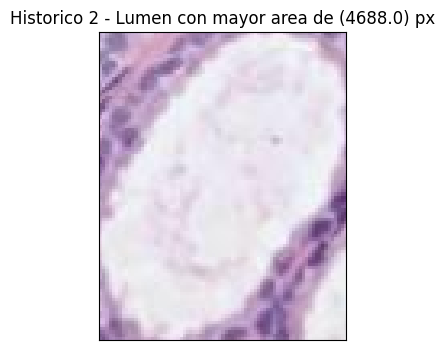

In [97]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.

from skimage.measure import label, regionprops

props = []

def obtener_propiedades_de_la_imagen(mask_lumen_aislado):
  labels, num_labels = label(mask_lumen_aislado, return_num=True)

  # Se obtiene las propiedades de cada label, para el siguiente punto.

  for posicion in range(1, num_labels + 1):
    a_label = labels == posicion

    prop = regionprops(a_label.astype(np.uint8))
    props.append(
        {
            "Lumen": posicion,
            "Area": np.round(prop[0].area, 4),
            "A. Bbox": np.round(prop[0].bbox_area, 4),
            "A. Convexa": np.round(prop[0].convex_area, 4),
            "Excentridad": np.round(prop[0].eccentricity, 4),
            "D. Equivalente": np.round(prop[0].equivalent_diameter, 4),
            "Extension": np.round(prop[0].extent, 4),
            "D. Feret": np.round(prop[0].feret_diameter_max, 4),
            "L. eje mayor": np.round(prop[0].major_axis_length, 4),
            "L. eje menor": np.round(prop[0].minor_axis_length, 4),
            "Orientacion": np.round(prop[0].orientation, 4),
            "Perimetro": np.round(prop[0].perimeter, 4),
            "Solidez": np.round(prop[0].solidity, 4),
            "Compacidad": np.round(4*math.pi*prop[0].area/prop[0].perimeter**2, 4)
        }
    )
  return props, labels

props_2, labels = obtener_propiedades_de_la_imagen(mask_lumen_aislado_2)

# Se halla la posicion y el area del lumen con el area mas grande
def hallando_el_area_y_lumen_mas_grande_de_imagen(props):
  areas = [prop["Area"] for prop in props]
  posicion_label = np.array(areas).argmax() + 1
  area_max = np.array(areas).max()
  lumen_con_mas_area = labels == posicion_label

  return area_max, lumen_con_mas_area

area_max, lumen_con_mas_area = hallando_el_area_y_lumen_mas_grande_de_imagen(props_2)

def hallando_bbox_de_imagen(lumen_con_mas_area):
  prop = regionprops(lumen_con_mas_area.astype(np.uint8)) # nos aseguramos u8.
  minr, minc, maxr, maxc = prop[0].bbox
  return minr, minc, maxr, maxc

minr, minc, maxr, maxc = hallando_bbox_de_imagen(lumen_con_mas_area)

## Visualizando
crop = original_imagen_2[minr:maxr, minc:maxc]

fig, axes = plt.subplots(1, 1, figsize=(12, 4))
axes.imshow(crop, cmap='gray');
axes.set_title(f"Historico 2 - Lumen con mayor area de ({area_max}) px");
axes.set_xticks([]);
axes.set_yticks([])
plt.show()

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado

In [98]:
## Obtenemos y pintamos la tabla con los valores del lumen con area mas grande.

prop_max_2 = max(props_2, key=lambda x: x["Area"])
prop_max_2 = [prop_max_2]
tabla_html = tabulate(prop_max_2, headers="keys", tablefmt="html")

estilo = """
<style>
table {
    border-collapse: collapse;
    width: 100%;
    font-family: Arial, sans-serif;
}
th {
    background-color: #6C3483;
    color: white;
    padding: 8px;
}
td {
    padding: 6px;
    text-align: center;
}
tr:nth-child(even) {
    background-color: #625f63;
}
tr:hover {
    background-color: #D2B4DE;
}
</style>
"""
display(HTML(estilo + tabla_html))

Lumen,Area,A. Bbox,A. Convexa,Excentridad,D. Equivalente,Extension,D. Feret,L. eje mayor,L. eje menor,Orientacion,Perimetro,Solidez,Compacidad
17,4688,7392,4883,0.8381,77.259,0.6342,104.809,104.892,57.2137,-0.5615,288.392,0.9601,0.7083
